# M5 Forecasting


Description:

>This is a kaggle competition, the fifth iteration, you will use hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) 
and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy

(https://www.kaggle.com/c/m5-forecasting-accuracy/overview)

**Files**:

>
* calendar.csv - Contains information about the dates on which the products are sold.
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
* sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
* sell_prices.csv - Contains information about the price of the products sold per store and date.
* sales_train_evaluation.csv - Available once month before competition deadline. Will include sales [d_1 - d_1941]

In [1]:

conda install -c conda-forge lightgbm


Solving environment: done

## Package Plan ##

  environment location: /Users/jacobywilkerson/opt/miniconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.4.5.1         |   py37hc8dfbb8_0         151 KB  conda-forge
    conda-4.8.3                |   py37hc8dfbb8_1         3.0 MB  conda-forge
    joblib-0.14.1              |             py_0         198 KB  conda-forge
    libblas-3.8.0              |      14_openblas          10 KB  conda-forge
    libcblas-3.8.0             |      14_openblas          10 KB  conda-forge
    libgfortran-3.0.1          |                0         495 KB  conda-forge
    liblapack-3.8.0            |      14_openblas          10 KB  conda-forge
    libopenblas-0.3.7          |       hd44dcd8_1         8.4 MB  conda-forge
    lightgbm-2.3.0             |   py37h0a44026_0         594 KB
    llvm-openmp

In [2]:
conda install -c conda-forge openmp 

Solving environment: done

## Package Plan ##

  environment location: /Users/jacobywilkerson/opt/miniconda3

  added / updated specs:
    - openmp


The following NEW packages will be INSTALLED:

  openmp             conda-forge/osx-64::openmp-8.0.1-0

The following packages will be DOWNGRADED:

  llvm-openmp                             10.0.0-h28b9765_0 --> 8.0.1-h770b8ee_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} numpy pandas seaborn scikit-learn matplotlib

Solving environment: done

## Package Plan ##

  environment location: /Users/jacobywilkerson/opt/miniconda3

  added / updated specs:
    - matplotlib
    - numpy
    - pandas
    - scikit-learn
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |         openblas          45 KB
    certifi-2020.4.5.1         |           py37_0         155 KB
    numpy-1.18.1               |   py37h0c13f30_0           5 KB
    numpy-base-1.18.1          |   py37ha711998_1         3.9 MB
    pandas-1.0.3               |   py37h6c726b0_0         7.7 MB
    scikit-learn-0.22.1        |   py37hebd9d1a_0         4.7 MB
    ------------------------------------------------------------
                                           Total:        16.4 MB

The following NEW packages will be INSTALLED:

  blas               pkgs/main/osx-64::blas-1.0-openblas
  cycler           

In [6]:
# Import Tools
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from itertools import cycle

pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import lightgbm as lgb
from datetime import datetime, timedelta
import gc

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')




plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

/Users/jacobywilkerson/opt/miniconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [7]:
## Decrease the memory

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [48]:
# Upload Sales Training Data
stv = pd.read_csv("sales_train_validation.csv")
stv_2 = stv[:5000]
stv_2.to_csv("sales_train_validation_sample.csv")

In [9]:
len(stv)

30490

In [10]:
stv.tail()

id      item_id  dept_id cat_id store_id  \
30485  FOODS_3_823_WI_3_validation  FOODS_3_823  FOODS_3  FOODS     WI_3   
30486  FOODS_3_824_WI_3_validation  FOODS_3_824  FOODS_3  FOODS     WI_3   
30487  FOODS_3_825_WI_3_validation  FOODS_3_825  FOODS_3  FOODS     WI_3   
30488  FOODS_3_826_WI_3_validation  FOODS_3_826  FOODS_3  FOODS     WI_3   
30489  FOODS_3_827_WI_3_validation  FOODS_3_827  FOODS_3  FOODS     WI_3   

      state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
30485       WI    0    0    2    2    0    3    1    4    1     0     0     3   
30486       WI    0    0    0    0    0    5    0    1    1     3     1     1   
30487       WI    0    6    0    2    2    4    1    8    5     2     7     5   
30488       WI    0    0    0    0    0    0    0    0    0     0     0     0   
30489       WI    0    0    0    0    0    0    0    0    0     0     0     0   

       d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
30485     4     4     0     0     1     0     1     1     7     7     3     6   
30486     0     4     2     0     1     2     1     1     0     0     0     0   
30487     3     5    20     8    10     3     3     4     7     2     3     5   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
30485     3     3     7    12     4     2     7     5    12     5     3     3   
30486     3     1     1     1     2     0     1     0     1     1     1     3   
30487     6     3     4     1     2     5     1     2     2     2     1     9   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
30485     7     6     4     6     3     6     2     3     4     1     1     3   
30486     3     4     4     3     6     1     0     1     2     3     0     1   
30487     8     1     6     3     3     4    10     4     6     3     2     1   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
30485     2     1     2     3     4     7     2     4     4     4     7     7   
30486     1     1     0     0     0     1     0     0     1     0     0     0   
30487     1     3     2     2     1     1     1     1     1     0     1     4   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
30485     2     4     7     4     4     7     3     4     2     3    10     6   
30486     1     2     0     1     2     1     2     0     1     1     0     1   
30487     0     0     1     3     1     1     1     3     0     1     1     1   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
30485     8     5     1     0     2     1     0     3     0     2     3     1   
30486     1     2     0     3     2     1     0     0     0     0     1     1   
30487     2     3     1     1     1     2     1     3     1     0     0     3   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
30485     1     1     7     1     4     2     2     0     0     0     5     1   
3048

In [11]:
stv.dtypes

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1909       int64
d_1910       int64
d_1911       int64
d_1912       int64
d_1913       int64
Length: 1919, dtype: object

In [12]:
stv.isna().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

In [13]:
len(stv.columns)

1919

In [14]:
stv.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)

## Visualizing the data
  
  > Let's first visualize the data for a single item

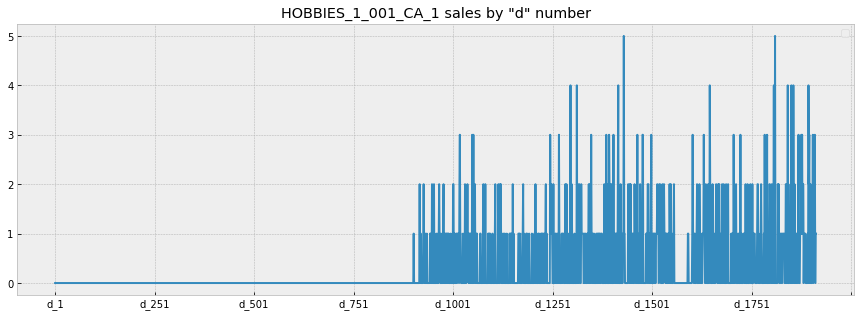

In [15]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'HOBBIES_1_001_CA_1_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='HOBBIES_1_001_CA_1 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

Looks like the above item wasn't on sale until about day 1001

Now let's add dates to the data

In [16]:
cal = pd.read_csv("calendar.csv")
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [17]:
# Let's look at data for California

# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


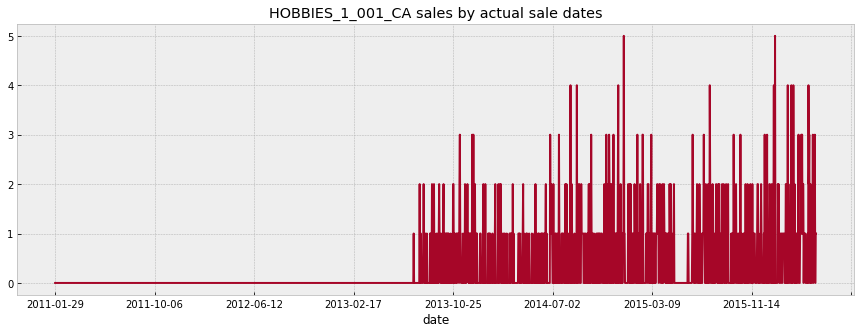

In [18]:
# Merge calendar on our items' data
example = stv.loc[stv['id'] == 'HOBBIES_1_001_CA_1_validation'][d_cols].T
example = example.rename(columns={0:'HOBBIES_1_001_CA_1'}) # Name the column correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index a column names "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['HOBBIES_1_001_CA_1'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='HOBBIES_1_001_CA sales by actual sale dates')
plt.show()

# Select two more items for examples
example2 = stv.loc[stv["id"] == 'FOODS_3_826_WI_3_validation'][d_cols].T
example2 = example2.rename(columns={30488:'FOODS_3_826_WI_3'}) # Name the column correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index a column named 'd'
example2 = example2.merge(cal, how='left', validate='1:1')

example3 = stv.loc[stv['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index a column named "d"
example3 = example3.merge(cal, how='left', validate='1:1')


Ask you can see above the dates are now showing on the x axis instead of the day number, so we see that
the product above did not begin selling until a little befor October

### Sale break down by time variables

Let's see sales by:

* Day of Week
* Month
* Year

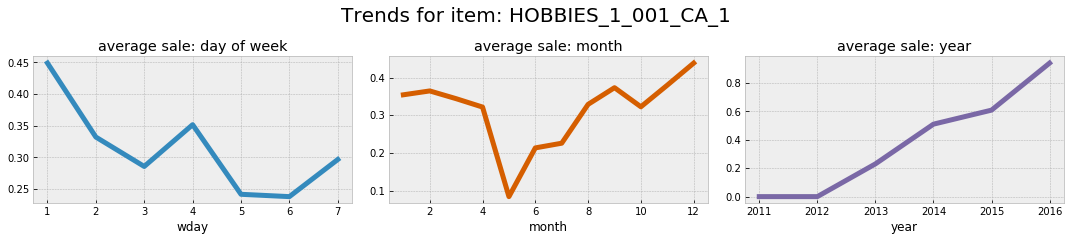

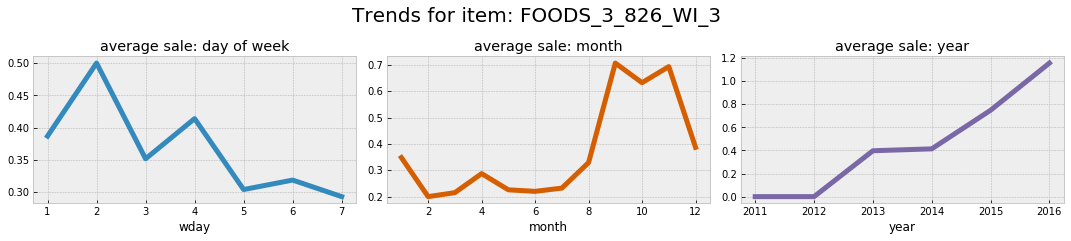

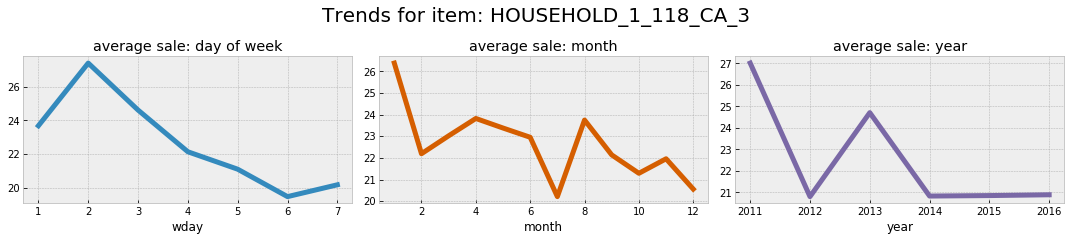

In [19]:
examples = ['HOBBIES_1_001_CA_1','FOODS_3_826_WI_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],

              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],

              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

### Combined Sales By Type

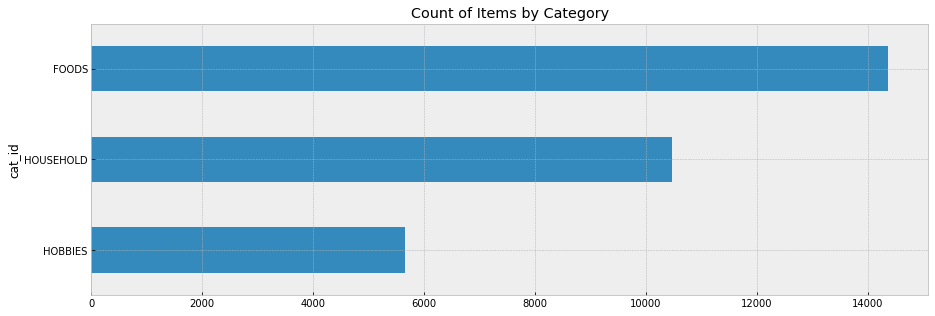

In [20]:
stv.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Count of Items by Category')
plt.show()

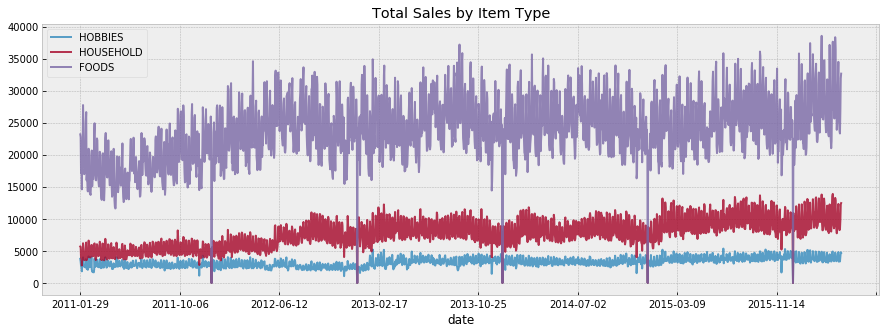

In [21]:
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(stv['cat_id'].unique())
plt.show()

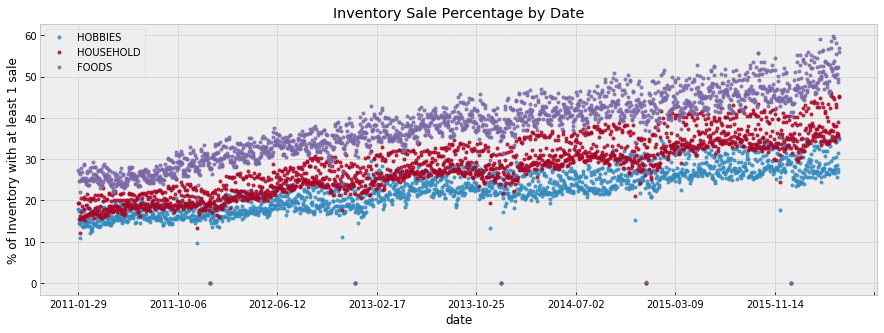

In [22]:
## Inventory sale percentage by date

past_sales_clipped = past_sales.clip(0, 1)
for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    (past_sales_clipped[items_col] \
        .mean(axis=1) * 100) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Inventory Sale Percentage by Date',
              style='.')
plt.ylabel('% of Inventory with at least 1 sale')
plt.legend(stv['cat_id'].unique())
plt.show()

### Sale by Store

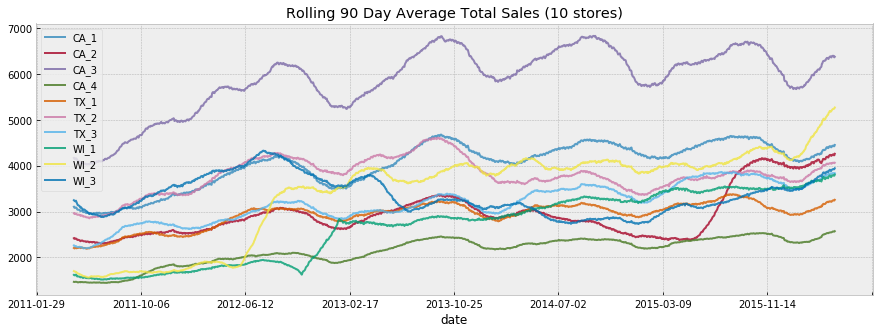

In [23]:
store_list = stv['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

### Preprocess Data before splitting into train and test dataµµ

Steps to preprocess:
>
* First we need to combine price data and  date data with the sales train data maybe
* Then convert all columns to numeric
* Split data into train and val data
* Choose model

In [24]:
stv.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [25]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


## Preprocess Data and Featuring Engineering

Imported Data
We have already imported the sales training data `stv` and the calendar data `cal`.
Now we need to import the sell price data and the sample submission


In [49]:
# stv = sales training data
# cal = calendar data

sell_prices = pd.read_csv("sell_prices.csv")
sell_prices_2 = sell_prices[:4000]
sell_prices_2.to_csv("sell_prices_2.csv")
sample_submission = pd.read_csv("sample_submission.csv")

stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [27]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [28]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [29]:
sample_submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }

        
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [31]:
pd.options.display.max_columns = 50
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [32]:
# Create a function to set up the dataframe that we will be used for training

def create_dt(is_train = True, nrows = None, first_day = 1200):

    sell_prices = pd.read_csv("sell_prices.csv", 
                             dtype = PRICE_DTYPES)

    # change the dtypes in the prices dataframe based on the PRICE_DTYPES dictionary
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            sell_prices[col] = sell_prices[col].cat.codes.astype("int16")
            sell_prices[col] -= sell_prices[col].min()

    cal = pd.read_csv("calendar.csv",
                      dtype = CAL_DTYPES)
    
    # change the date column in the calendar data frame to datetime
    cal["date"] = pd.to_datetime(cal["date"])

    # change the dtypes in the calendar dataframe based on the CAL_DTYPES dictionary
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    #Set the start day 1
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)

    #create a variable to set the number columns to be the names of the days in
    # range from start day to last day
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]

    # create a variable to name of the category columns
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']

    # create a variable to change the dtype of all numcols to be float32
    dtype = {numcol:"float32" for numcol in numcols} 

    # update the dtype in the catcols array to be category except for the "id"
    dtype.update({col: "category" for col in catcols if col != "id"})

    # Upload the dataframe that we are preprocessing and include parameters for it
    dt = pd.read_csv("sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    # change the catcols columns in the df to type "int16" except the "id" column
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()

    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan

    # change the format of the dataframe based on the catcols columns 
    # transform the "days" into a column
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    #merge the cal dataframe and the prices dataframe with the training dataframe 
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(sell_prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [33]:
# create function to add feature columns to the training dataframe

def create_fea(dt):
    
    # Set number of lags we'll use
    lags = [7, 28]
   
    # create a variable to name the lag columns
    lag_cols = [f"lag_{lag}" for lag in lags ]

    # create a lag column that is based off the lag of sales for each ID
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    # create columns that calculate the rolling lag mean for each ID in the lag column
    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
   
    #     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    # change the date features in our dataframe to int16 dtype and a few date features
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [34]:
FIRST_DAY = 375 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [35]:
%%time

df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

CPU times: user 33.6 s, sys: 13.5 s, total: 47 s
Wall time: 51.3 s


(40290828, 22)

In [36]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_375,0.0,2012-02-07,11202,5,4,2,2012,0,0,0,0,1.0,1.0,0.0,3.97
1,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_376,0.0,2012-02-08,11202,6,5,2,2012,0,0,0,0,1.0,0.0,1.0,3.97
2,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_377,0.0,2012-02-09,11202,4,6,2,2012,0,0,0,0,1.0,1.0,1.0,3.97
3,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_378,1.0,2012-02-10,11202,0,7,2,2012,0,0,0,0,1.0,0.0,0.0,3.97
4,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_375,0.0,2012-02-07,11202,5,4,2,2012,0,0,0,0,1.0,1.0,0.0,4.34


In [37]:
# run the create features on the dataframe to add the lag mean columns
create_fea(df)
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_375,0.0,2012-02-07,11202,5,4,2,2012,0,0,0,0,1.0,1.0,0.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,6,1,7
1,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_376,0.0,2012-02-08,11202,6,5,2,2012,0,0,0,0,1.0,0.0,1.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,6,1,8
2,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_377,0.0,2012-02-09,11202,4,6,2,2012,0,0,0,0,1.0,1.0,1.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,6,1,9
3,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_378,1.0,2012-02-10,11202,0,7,2,2012,0,0,0,0,1.0,0.0,0.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,6,1,10
4,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_375,0.0,2012-02-07,11202,5,4,2,2012,0,0,0,0,1.0,1.0,0.0,4.34,NaN,NaN,NaN,NaN,NaN,NaN,6,1,7


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40290828 entries, 0 to 40290827
Data columns (total 31 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  lag_7         float32       
 23  lag_28        float32       
 

In [39]:
# See which columns have "na" and how many
df.isna().sum()

id                    0
item_id               0
dept_id               0
store_id              0
cat_id                0
state_id              0
d                     0
sales                 0
date                  0
wm_yr_wk              0
weekday               0
wday                  0
month                 0
year                  0
event_name_1          0
event_type_1          0
event_name_2          0
event_type_2          0
snap_CA               0
snap_TX               0
snap_WI               0
sell_price            0
lag_7            213430
lag_28           853720
rmean_7_7        396370
rmean_28_7      1036660
rmean_7_28      1036660
rmean_28_28     1676950
week                  0
quarter               0
mday                  0
dtype: int64

In [40]:
# Delete "NA"
df.dropna(inplace = True)

## Modeling

We will be using LightGBM

In [41]:
# Set up training data columns

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [42]:
np.random.seed(42)

# set up the training data and the valid data
fake_valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
                              categorical_feature=cat_feats,
                 free_raw_data=False)

In [43]:
del df, X_train, y_train, fake_valid_inds,train_inds ; gc.collect()

20

In [44]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 1200,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
}


params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "save_binary": True,
        "learning_rate" : 0.015,
        "max_bin": 120,
       "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 240,
    'num_leaves': 180,
    "min_data_in_leaf": 100,
}


In [45]:
m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=20)

[20]	valid_0's rmse: 3.72259
[40]	valid_0's rmse: 3.42745
[60]	valid_0's rmse: 3.19099
[80]	valid_0's rmse: 3.00285
[100]	valid_0's rmse: 2.85451
[120]	valid_0's rmse: 2.73842
[140]	valid_0's rmse: 2.6484
[160]	valid_0's rmse: 2.57891
[180]	valid_0's rmse: 2.52549
[200]	valid_0's rmse: 2.48451
[220]	valid_0's rmse: 2.45297
[240]	valid_0's rmse: 2.4287


In [ ]:
%%time

alphas = [1.028, 1.023, 1.018]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_dt(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier by kyakovlev



    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
#     te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
#                                                                           "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)

0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
0 1.028 0.3333333333333333
0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2